<a href="https://colab.research.google.com/github/shila121/projects/blob/main/Bank_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
# import the data

data = pd.read_csv('german_credit_data.csv')
print(data.head())

# categorical columns
catCols = data.select_dtypes('object').columns
print('categorical columns:',catCols,len(catCols))

# numerical columns
numCols = data.select_dtypes('number').columns
print('numeric columns:',numCols,len(numCols))

   Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  
0           1169         6             radio/TV  
1           5951        48             radio/TV  
2           2096        12            education  
3           7882        42  furniture/equipment  
4           4870        24                  car  
categorical columns: Index(['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'], dtype='object') 5
numeric columns: Index(['Unnamed: 0', 'Age', 'Job', 'Credit amount', 'Duration'], dtype='object') 5


In [3]:
# checking the missing data
data.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

In [5]:
import seaborn as sns
for i in ['Saving accounts', 'Checking account']:
  print(data[i].value_counts())


little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64


In [6]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

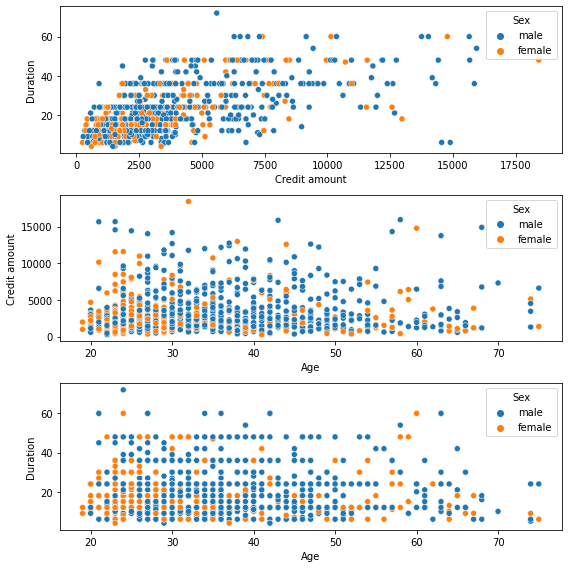

In [7]:
scatters(data, h="Sex")

AttributeError: ignored

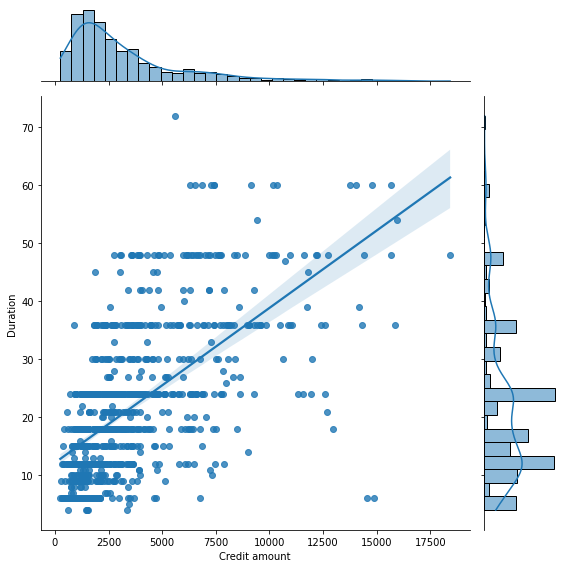

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import scipy.stats as stats
r1 = sns.jointplot(x="Credit amount",y="Duration", data=data, kind="reg", height=8)
r1.annotate(stats.pearsonr)
plt.show()

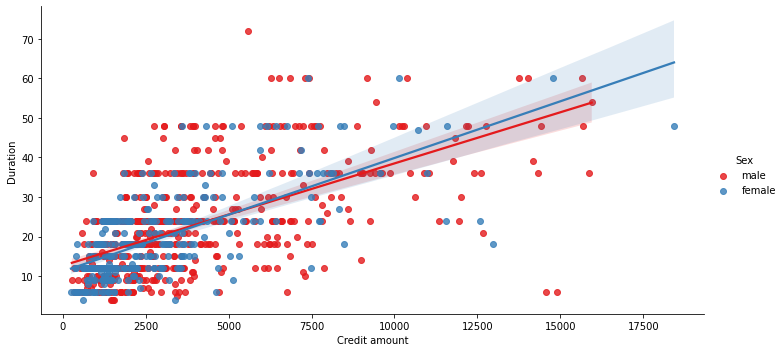

In [10]:
sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=data, palette="Set1", aspect=2)
plt.show()

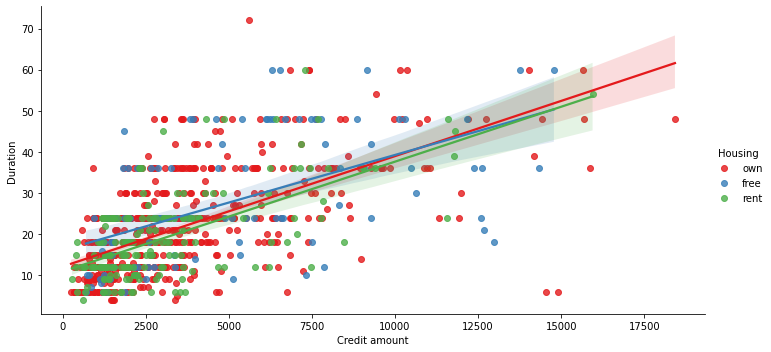

In [11]:
sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=data, palette="Set1", aspect=2)
plt.show()

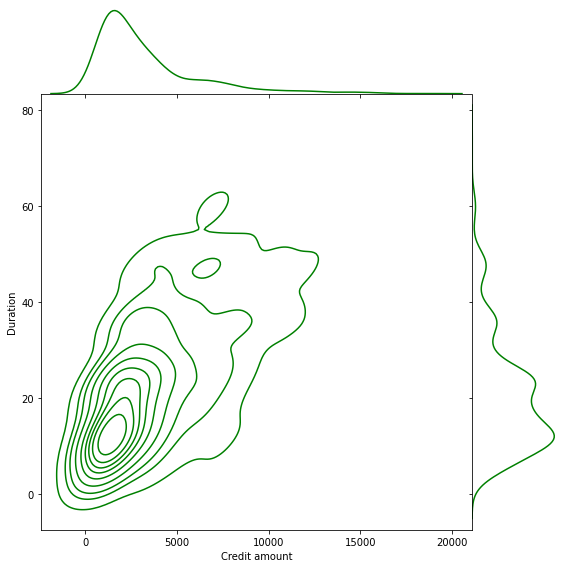

In [12]:
sns.jointplot("Credit amount","Duration", data=data, kind="kde", space=0, color="g",  height=8)
plt.show()

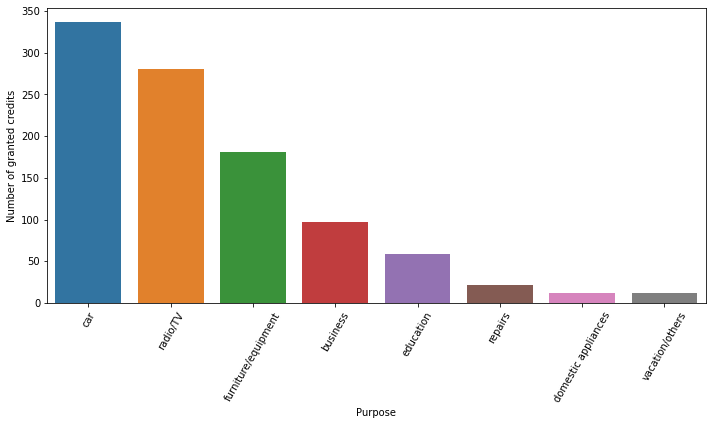

In [13]:
n_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel("Number of granted credits")
plt.tight_layout()

In [14]:
def boxes(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x,y=y, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()

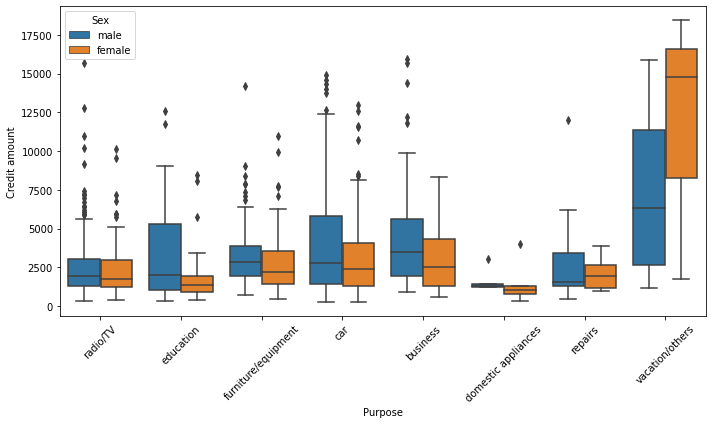

In [15]:
boxes("Purpose","Credit amount","Sex")

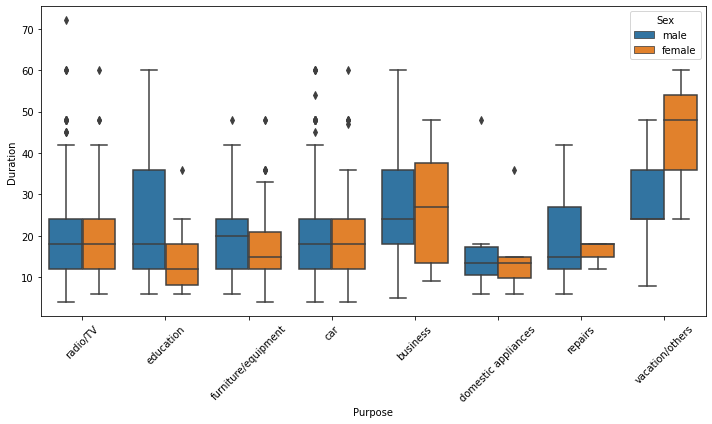

In [16]:
boxes("Purpose","Duration","Sex")

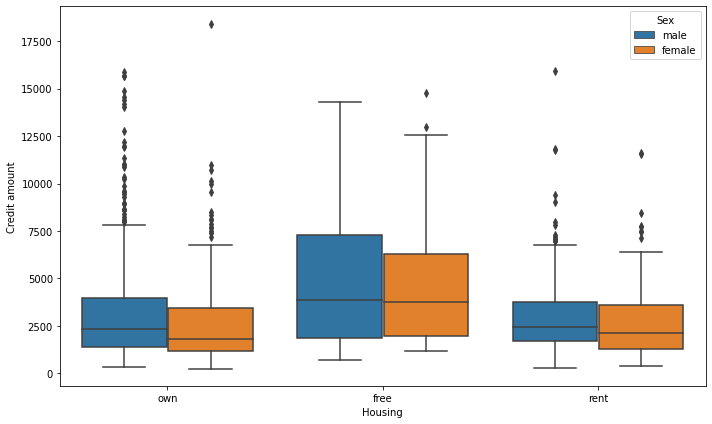

In [17]:
boxes("Housing","Credit amount","Sex",r=0)

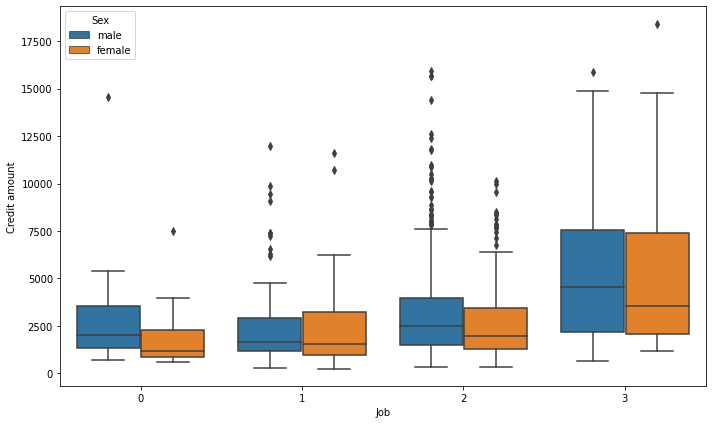

In [18]:
boxes("Job","Credit amount","Sex",r=0)

Text(0.5, 0, 'Age')

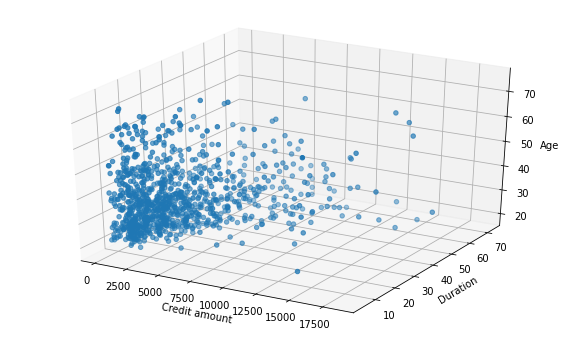

In [19]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["Credit amount"], data["Duration"], data["Age"])
ax.set_xlabel("Credit amount")
ax.set_ylabel("Duration")
ax.set_zlabel("Age")

In [20]:
#Selecting columns for clusterisation with k-means
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = data.loc[:,selected_cols]

In [21]:
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Credit amount"], ax=ax2)
    sns.distplot(df["Duration"], ax=ax3)
    plt.tight_layout()

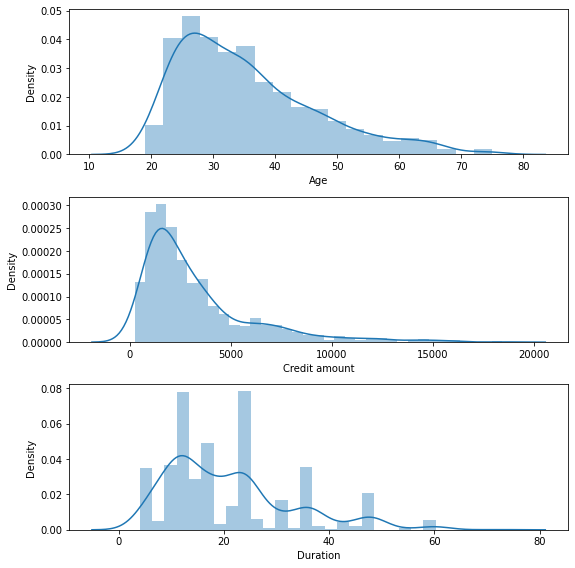

In [22]:
distributions(cluster_data)

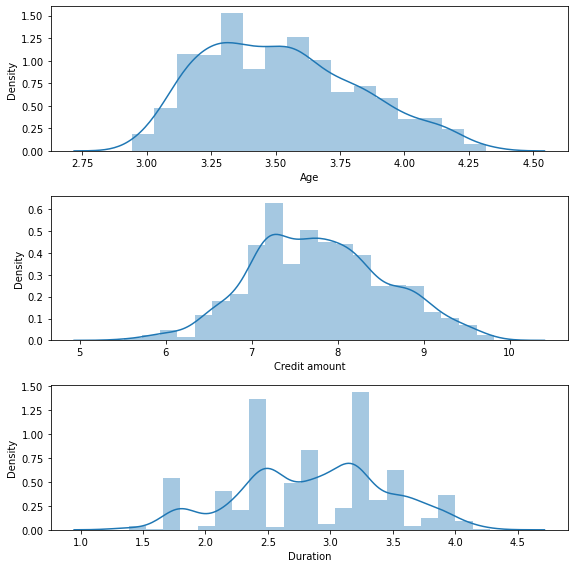

In [23]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

In [24]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

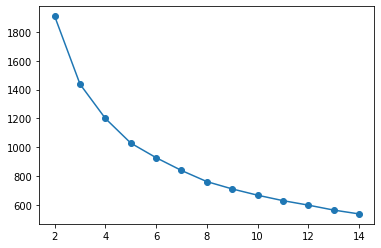

In [25]:
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')

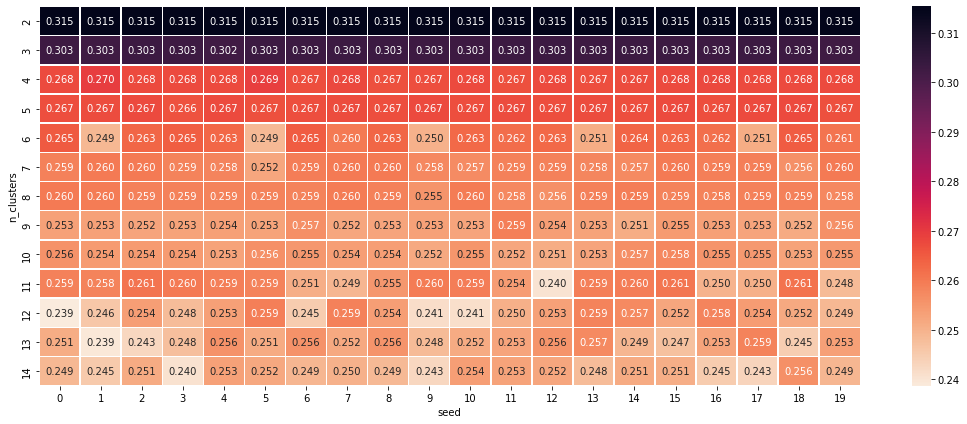

In [26]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        #print("For n_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

In [27]:
kmeans_sel = KMeans(n_clusters=3, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

For n_clusters = 3  and seed = 19 
The average silhouette_score is : 0.30255813750380023


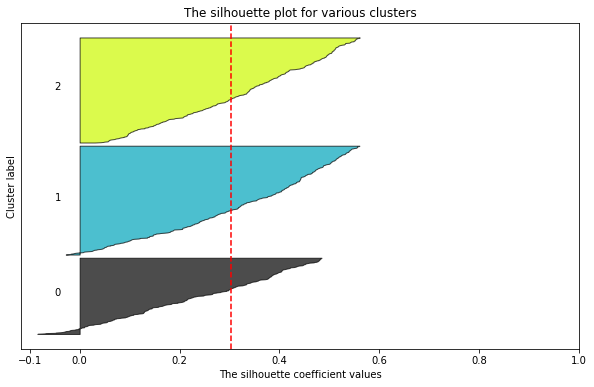

In [28]:
import matplotlib.cm as cm

clusterer = KMeans(n_clusters=3, random_state=1)
cluster_labels = clusterer.fit_predict(cluster_scaled)
silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
print("For n_clusters =", 3," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(cluster_scaled, cluster_labels)

fig, ax1 = plt.subplots(figsize=(10,6))

y_lower = 10
for i in range(3):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 3)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor="black", alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.get_yaxis().set_ticks([])
ax1.set_title("The silhouette plot for various clusters")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

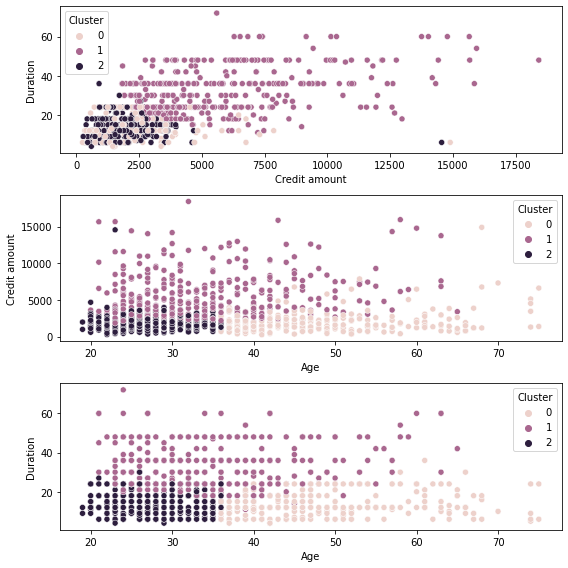

In [29]:
scatters(clustered_data, 'Cluster')

In [30]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,48.5,1970.3,13.9
1,34.0,5665.4,32.2
2,27.7,1736.3,14.3


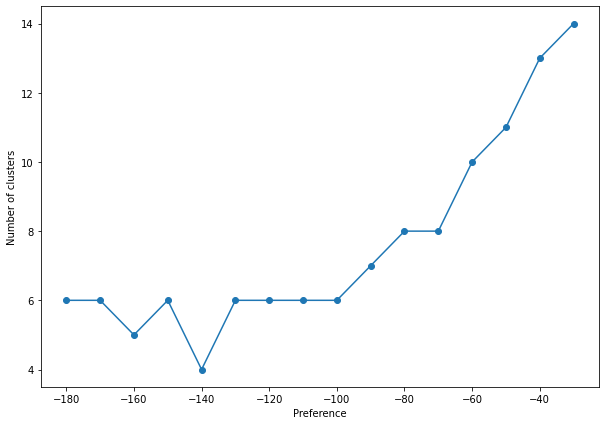

In [31]:
preferences = np.arange(-30,-190,-10)
clusters = []

for p in preferences:
    af = AffinityPropagation(preference=p, damping=0.6, max_iter=400, verbose=False).fit(cluster_scaled)
    labels_af = pd.DataFrame(af.labels_)
    clusters.append(len(af.cluster_centers_indices_))

plt.figure(figsize=(10,7))
plt.xlabel("Preference")
plt.ylabel("Number of clusters")
plt.plot(preferences,clusters, marker='o')

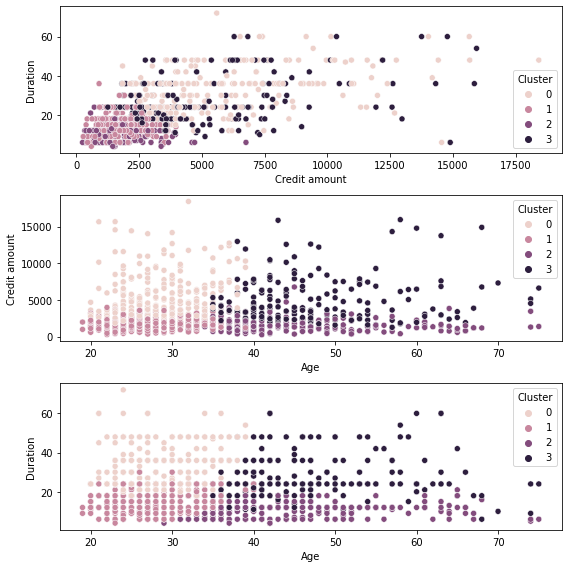

In [32]:
af = AffinityPropagation(preference=-140, damping=0.6, verbose=False).fit(cluster_scaled)
labels_af = pd.DataFrame(af.labels_)
n_clusters_ = len(af.cluster_centers_indices_)

clustered_data_af = cluster_data.assign(Cluster=labels_af)
scatters(clustered_data_af,'Cluster')

grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)

In [33]:
grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)
grouped_af

,Age,Credit amount,Duration
Cluster,,,
0,28.7,5593.7,32.2
1,27.9,1654.3,15.1
2,46.0,1551.7,10.7
3,47.5,4977.9,27.6
